# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [34]:
path = '../../../Base de datos/Trayectorias 50 eval'

## Datos de entrenamiento

### Datos

In [35]:
varftrain = np.load(path + '/varftrain.npy')

In [36]:
np.shape(varftrain)

(7000, 10, 2, 50)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(2000, 10, 2, 50)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(1000, 10, 2, 50)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 50), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
#model = Sequential()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,50)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(12, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7)
])


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 50)                50050     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 12)                312       
                                                                 
 dense_3 (Dense)             (None, 25)                325       
                                                        

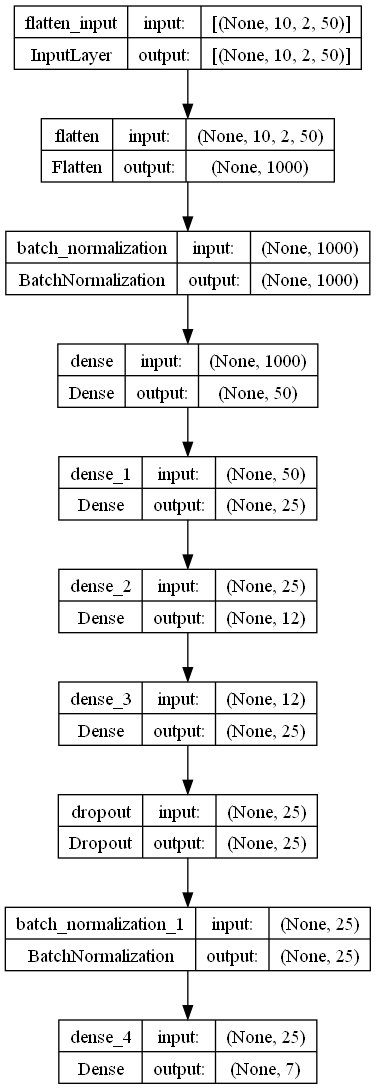

In [22]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [23]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [24]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [25]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [26]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, 
                    callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 3ms/step - loss: 31.1621 - mae: 4.6068 - val_loss: 30.7851 - val_mae: 4.5501 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 0s 2ms/step - loss: 27.4315 - mae: 4.3154 - val_loss: 25.2936 - val_mae: 4.0932 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 0s 2ms/step - loss: 21.7477 - mae: 3.7355 - val_loss: 16.7519 - val_mae: 3.1669 - lr: 0.0010
Epoch 4/1000
70/70 [==============================] - 0s 2ms/step - loss: 15.0529 - mae: 2.9522 - val_loss: 10.0248 - val_mae: 2.2963 - lr: 0.0010
Epoch 5/1000
70/70 [==============================] - 0s 2ms/step - loss: 10.4584 - mae: 2.3551 - val_loss: 7.7646 - val_mae: 1.9681 - lr: 0.0010
Epoch 6/1000
70/70 [==============================] - 0s 2ms/step - loss: 8.5886 - mae: 2.1075 - val_loss: 7.2408 - val_mae: 1.8863 - lr: 0.0010
Epoch 7/1000
70/70 [==============================] - 0s 2ms/step - loss: 7.8767 - mae: 2.0226 - val_loss: 6.6662 - val_m

70/70 [==============================] - 0s 2ms/step - loss: 4.7592 - mae: 1.6137 - val_loss: 4.4135 - val_mae: 1.4893 - lr: 0.0010
Epoch 114/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.7494 - mae: 1.6070 - val_loss: 4.3584 - val_mae: 1.4898 - lr: 0.0010
Epoch 115/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.7049 - mae: 1.5993 - val_loss: 4.3229 - val_mae: 1.4859 - lr: 0.0010
Epoch 116/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.7033 - mae: 1.6008 - val_loss: 4.3337 - val_mae: 1.4784 - lr: 0.0010
Epoch 117/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.7320 - mae: 1.6078 - val_loss: 4.3743 - val_mae: 1.4853 - lr: 0.0010
Epoch 118/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.7197 - mae: 1.6034 - val_loss: 4.3192 - val_mae: 1.4787 - lr: 0.0010
Epoch 119/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.7296 - mae: 1.6068 - val_loss: 4.3467 - val_mae: 1.4837

Epoch 169/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5695 - mae: 1.5818 - val_loss: 4.1646 - val_mae: 1.4430 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5822 - mae: 1.5830 - val_loss: 4.2219 - val_mae: 1.4623 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5826 - mae: 1.5850 - val_loss: 4.1399 - val_mae: 1.4360 - lr: 0.0010
Epoch 172/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5426 - mae: 1.5711 - val_loss: 4.1553 - val_mae: 1.4585 - lr: 0.0010
Epoch 173/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5740 - mae: 1.5827 - val_loss: 4.1578 - val_mae: 1.4590 - lr: 0.0010
Epoch 174/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5286 - mae: 1.5696 - val_loss: 4.1506 - val_mae: 1.4423 - lr: 0.0010
Epoch 175/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5532 - mae: 1.5764 - val_loss: 4.1540 - 

Epoch 225/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4617 - mae: 1.5632 - val_loss: 4.1090 - val_mae: 1.4313 - lr: 0.0010
Epoch 226/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4571 - mae: 1.5615 - val_loss: 4.0998 - val_mae: 1.4257 - lr: 0.0010
Epoch 227/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4914 - mae: 1.5665 - val_loss: 4.0976 - val_mae: 1.4227 - lr: 0.0010
Epoch 228/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4947 - mae: 1.5672 - val_loss: 4.1499 - val_mae: 1.4463 - lr: 0.0010
Epoch 229/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4726 - mae: 1.5636 - val_loss: 4.0897 - val_mae: 1.4249 - lr: 0.0010
Epoch 230/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.5007 - mae: 1.5690 - val_loss: 4.1424 - val_mae: 1.4421 - lr: 0.0010
Epoch 231/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4656 - mae: 1.5616 - val_loss: 4.1196 - 

Epoch 281/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4294 - mae: 1.5587 - val_loss: 4.1193 - val_mae: 1.4274 - lr: 0.0010
Epoch 282/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3749 - mae: 1.5415 - val_loss: 4.0681 - val_mae: 1.4206 - lr: 0.0010
Epoch 283/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.4140 - mae: 1.5511 - val_loss: 4.1061 - val_mae: 1.4323 - lr: 0.0010
Epoch 284/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3968 - mae: 1.5487 - val_loss: 4.0534 - val_mae: 1.4118 - lr: 0.0010
Epoch 285/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3709 - mae: 1.5445 - val_loss: 4.1269 - val_mae: 1.4258 - lr: 0.0010
Epoch 286/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3924 - mae: 1.5471 - val_loss: 4.0786 - val_mae: 1.4169 - lr: 0.0010
Epoch 287/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3916 - mae: 1.5473 - val_loss: 4.1494 - 

Epoch 337/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3401 - mae: 1.5353 - val_loss: 4.0654 - val_mae: 1.4219 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3672 - mae: 1.5417 - val_loss: 4.0380 - val_mae: 1.4072 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3589 - mae: 1.5394 - val_loss: 4.0888 - val_mae: 1.4298 - lr: 0.0010
Epoch 340/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3358 - mae: 1.5355 - val_loss: 4.1328 - val_mae: 1.4399 - lr: 0.0010
Epoch 341/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3381 - mae: 1.5364 - val_loss: 4.1315 - val_mae: 1.4334 - lr: 0.0010
Epoch 342/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3657 - mae: 1.5423 - val_loss: 4.1428 - val_mae: 1.4275 - lr: 0.0010
Epoch 343/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3361 - mae: 1.5378 - val_loss: 4.0891 - 

Epoch 393/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3142 - mae: 1.5299 - val_loss: 4.0568 - val_mae: 1.4228 - lr: 0.0010
Epoch 394/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3200 - mae: 1.5330 - val_loss: 4.1009 - val_mae: 1.4212 - lr: 0.0010
Epoch 395/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3412 - mae: 1.5380 - val_loss: 3.9993 - val_mae: 1.4133 - lr: 0.0010
Epoch 396/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.2704 - mae: 1.5204 - val_loss: 4.0317 - val_mae: 1.4118 - lr: 0.0010
Epoch 397/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3249 - mae: 1.5367 - val_loss: 4.0670 - val_mae: 1.4024 - lr: 0.0010
Epoch 398/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.3351 - mae: 1.5329 - val_loss: 4.0341 - val_mae: 1.4070 - lr: 0.0010
Epoch 399/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.2852 - mae: 1.5273 - val_loss: 4.0169 - 

70/70 [==============================] - 0s 2ms/step - loss: 4.2037 - mae: 1.5075 - val_loss: 4.0659 - val_mae: 1.4092 - lr: 8.3500e-04
Epoch 502/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.2462 - mae: 1.5168 - val_loss: 4.0394 - val_mae: 1.4071 - lr: 8.3335e-04
Epoch 503/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.2406 - mae: 1.5143 - val_loss: 4.0319 - val_mae: 1.3926 - lr: 8.3170e-04
Epoch 504/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1993 - mae: 1.5081 - val_loss: 4.0145 - val_mae: 1.3938 - lr: 8.3005e-04
Epoch 505/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.2435 - mae: 1.5156 - val_loss: 3.9890 - val_mae: 1.3903 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.2266 - mae: 1.5138 - val_loss: 4.0126 - val_mae: 1.3983 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.2318 - mae: 1.5144 - val_loss: 

70/70 [==============================] - 0s 2ms/step - loss: 4.1626 - mae: 1.5034 - val_loss: 4.0099 - val_mae: 1.3922 - lr: 6.5680e-04
Epoch 610/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1523 - mae: 1.4973 - val_loss: 4.0025 - val_mae: 1.3927 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1332 - mae: 1.4965 - val_loss: 4.0600 - val_mae: 1.4003 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1745 - mae: 1.5043 - val_loss: 4.0484 - val_mae: 1.3956 - lr: 6.5185e-04
Epoch 613/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1647 - mae: 1.5007 - val_loss: 4.0956 - val_mae: 1.4007 - lr: 6.5020e-04
Epoch 614/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1253 - mae: 1.4937 - val_loss: 4.0434 - val_mae: 1.3996 - lr: 6.4855e-04
Epoch 615/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1542 - mae: 1.5006 - val_loss: 

70/70 [==============================] - 0s 2ms/step - loss: 4.1059 - mae: 1.4908 - val_loss: 4.0535 - val_mae: 1.3904 - lr: 4.7860e-04
Epoch 718/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1029 - mae: 1.4891 - val_loss: 4.0294 - val_mae: 1.3871 - lr: 4.7695e-04
Epoch 719/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0894 - mae: 1.4873 - val_loss: 4.0415 - val_mae: 1.4005 - lr: 4.7530e-04
Epoch 720/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1447 - mae: 1.5026 - val_loss: 4.0501 - val_mae: 1.3993 - lr: 4.7365e-04
Epoch 721/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.1024 - mae: 1.4910 - val_loss: 3.9855 - val_mae: 1.3828 - lr: 4.7200e-04
Epoch 722/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0820 - mae: 1.4872 - val_loss: 4.0358 - val_mae: 1.3876 - lr: 4.7035e-04
Epoch 723/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0645 - mae: 1.4841 - val_loss: 

70/70 [==============================] - 0s 2ms/step - loss: 4.0207 - mae: 1.4750 - val_loss: 4.0191 - val_mae: 1.3891 - lr: 3.0040e-04
Epoch 826/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0337 - mae: 1.4765 - val_loss: 3.9808 - val_mae: 1.3809 - lr: 2.9875e-04
Epoch 827/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0244 - mae: 1.4740 - val_loss: 3.9927 - val_mae: 1.3864 - lr: 2.9710e-04
Epoch 828/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0384 - mae: 1.4808 - val_loss: 3.9917 - val_mae: 1.3734 - lr: 2.9545e-04
Epoch 829/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0730 - mae: 1.4864 - val_loss: 3.9912 - val_mae: 1.3776 - lr: 2.9380e-04
Epoch 830/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0218 - mae: 1.4790 - val_loss: 3.9846 - val_mae: 1.3798 - lr: 2.9215e-04
Epoch 831/1000
70/70 [==============================] - 0s 2ms/step - loss: 4.0178 - mae: 1.4757 - val_loss: 

70/70 [==============================] - 0s 2ms/step - loss: 3.9771 - mae: 1.4676 - val_loss: 3.9794 - val_mae: 1.3777 - lr: 1.2220e-04
Epoch 934/1000
70/70 [==============================] - 0s 2ms/step - loss: 3.9569 - mae: 1.4632 - val_loss: 3.9604 - val_mae: 1.3721 - lr: 1.2055e-04
Epoch 935/1000
70/70 [==============================] - 0s 2ms/step - loss: 3.9980 - mae: 1.4723 - val_loss: 3.9725 - val_mae: 1.3747 - lr: 1.1890e-04
Epoch 936/1000
70/70 [==============================] - 0s 2ms/step - loss: 3.9798 - mae: 1.4700 - val_loss: 3.9715 - val_mae: 1.3760 - lr: 1.1725e-04
Epoch 937/1000
70/70 [==============================] - 0s 2ms/step - loss: 3.9985 - mae: 1.4721 - val_loss: 3.9663 - val_mae: 1.3744 - lr: 1.1560e-04
Epoch 938/1000
70/70 [==============================] - 0s 2ms/step - loss: 3.9366 - mae: 1.4579 - val_loss: 3.9754 - val_mae: 1.3768 - lr: 1.1395e-04
Epoch 939/1000
70/70 [==============================] - 0s 2ms/step - loss: 3.9691 - mae: 1.4646 - val_loss: 

# Analizamos accuracy y loss

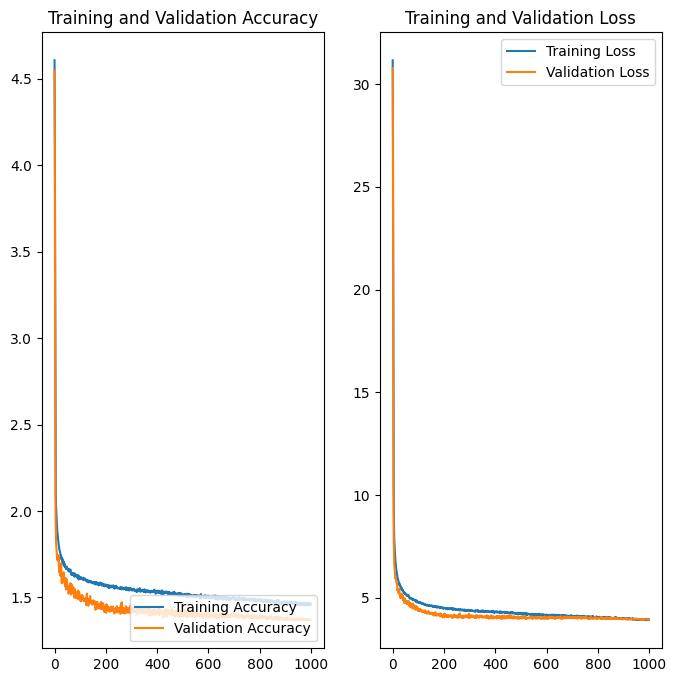

In [28]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [54]:
test_loss, test_acc = model.evaluate(varfval,coefvarfval)

32/32 [==============================] - 0s 675us/step - loss: 3.9451 - mae: 1.3702


In [55]:
predictions = model.predict(varfval)

32/32 [==============================] - 0s 579us/step


In [56]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarfval, predictions)

# Calcula la desviación estándar del error
error = coefvarfval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.3702489187504565, Desviación estándar del error: 1.9081855045284457, Error absoluto máximo: 7.924156904220581


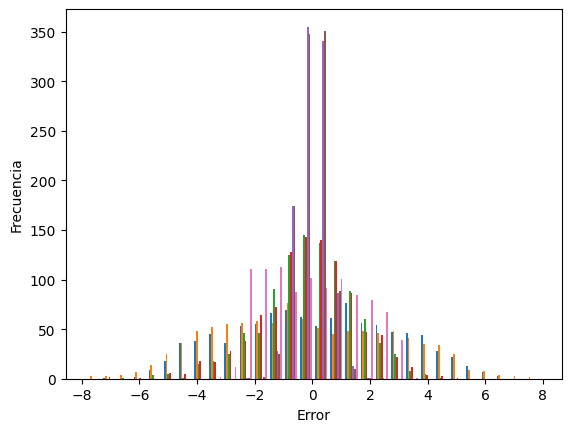

In [57]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [58]:
from sklearn.metrics import r2_score
r2 = r2_score(coefvarfval, predictions)
r2

0.5440447345865981

In [59]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

3.3215368270874026

# Guardamos los datos Accuracy y Loss

In [29]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historytrayec50.csv', index=False)

# Guardamos el modelo

In [30]:
path_to_save = '../../..//Modelos/Modelos 20,50'

In [31]:
model.save(path_to_save + '/trayectorias50.h5')

# Importamos el modelo

In [32]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [33]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/trayectorias50.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [101]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 50)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[5, 1, 6, 6, 6, 3, 4]
(10, 2, 50)


In [102]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [103]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 12ms/step
[[4. 3. 5. 5. 5. 3. 2.]]


In [104]:
one_dim_array = new_predictions.flatten()

In [105]:
from sklearn.metrics import mean_absolute_error

# Asegúrate de que coef1 y new_predictions son ambos arrays de numpy o listas con el mismo tamaño
mae = mean_absolute_error(coef1, one_dim_array)

print("El Mean Absolute Error es:", mae)

El Mean Absolute Error es: 1.1428571428571428


## Graficamos con los coeficientes reales

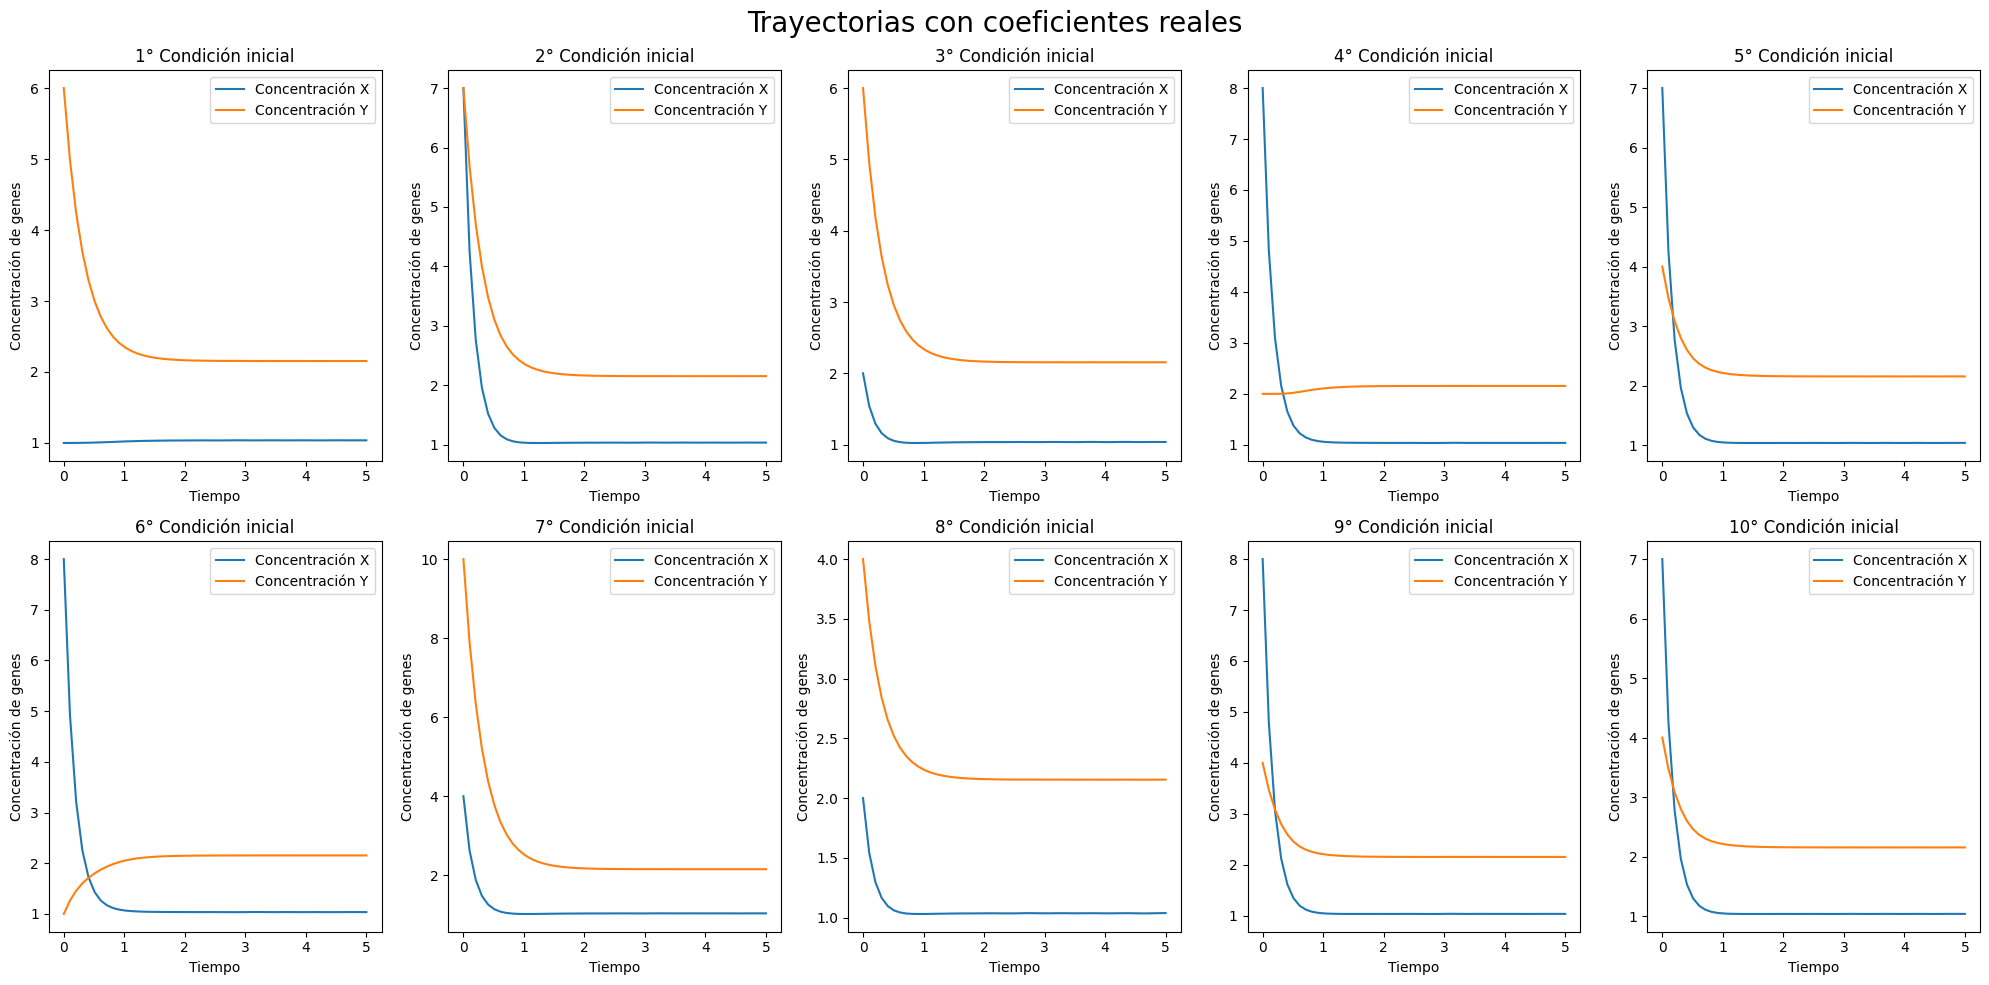

In [106]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [107]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

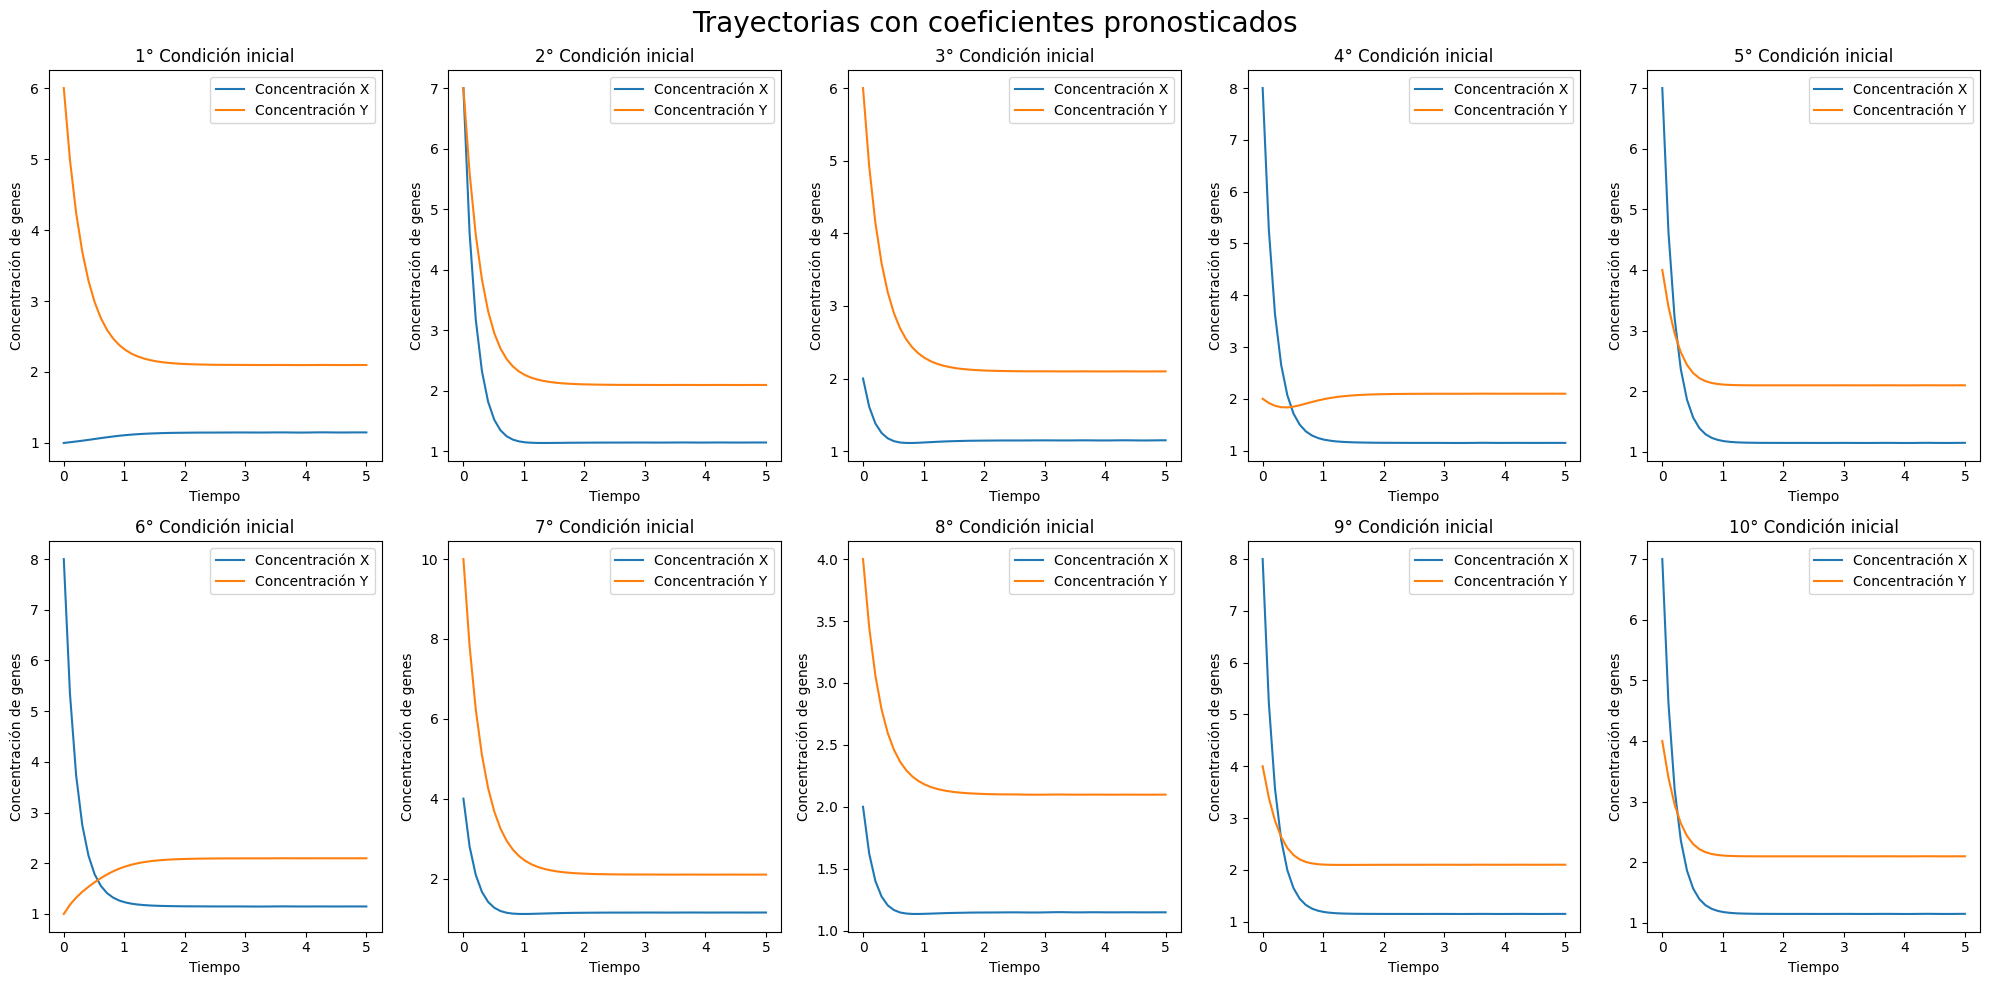

In [108]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

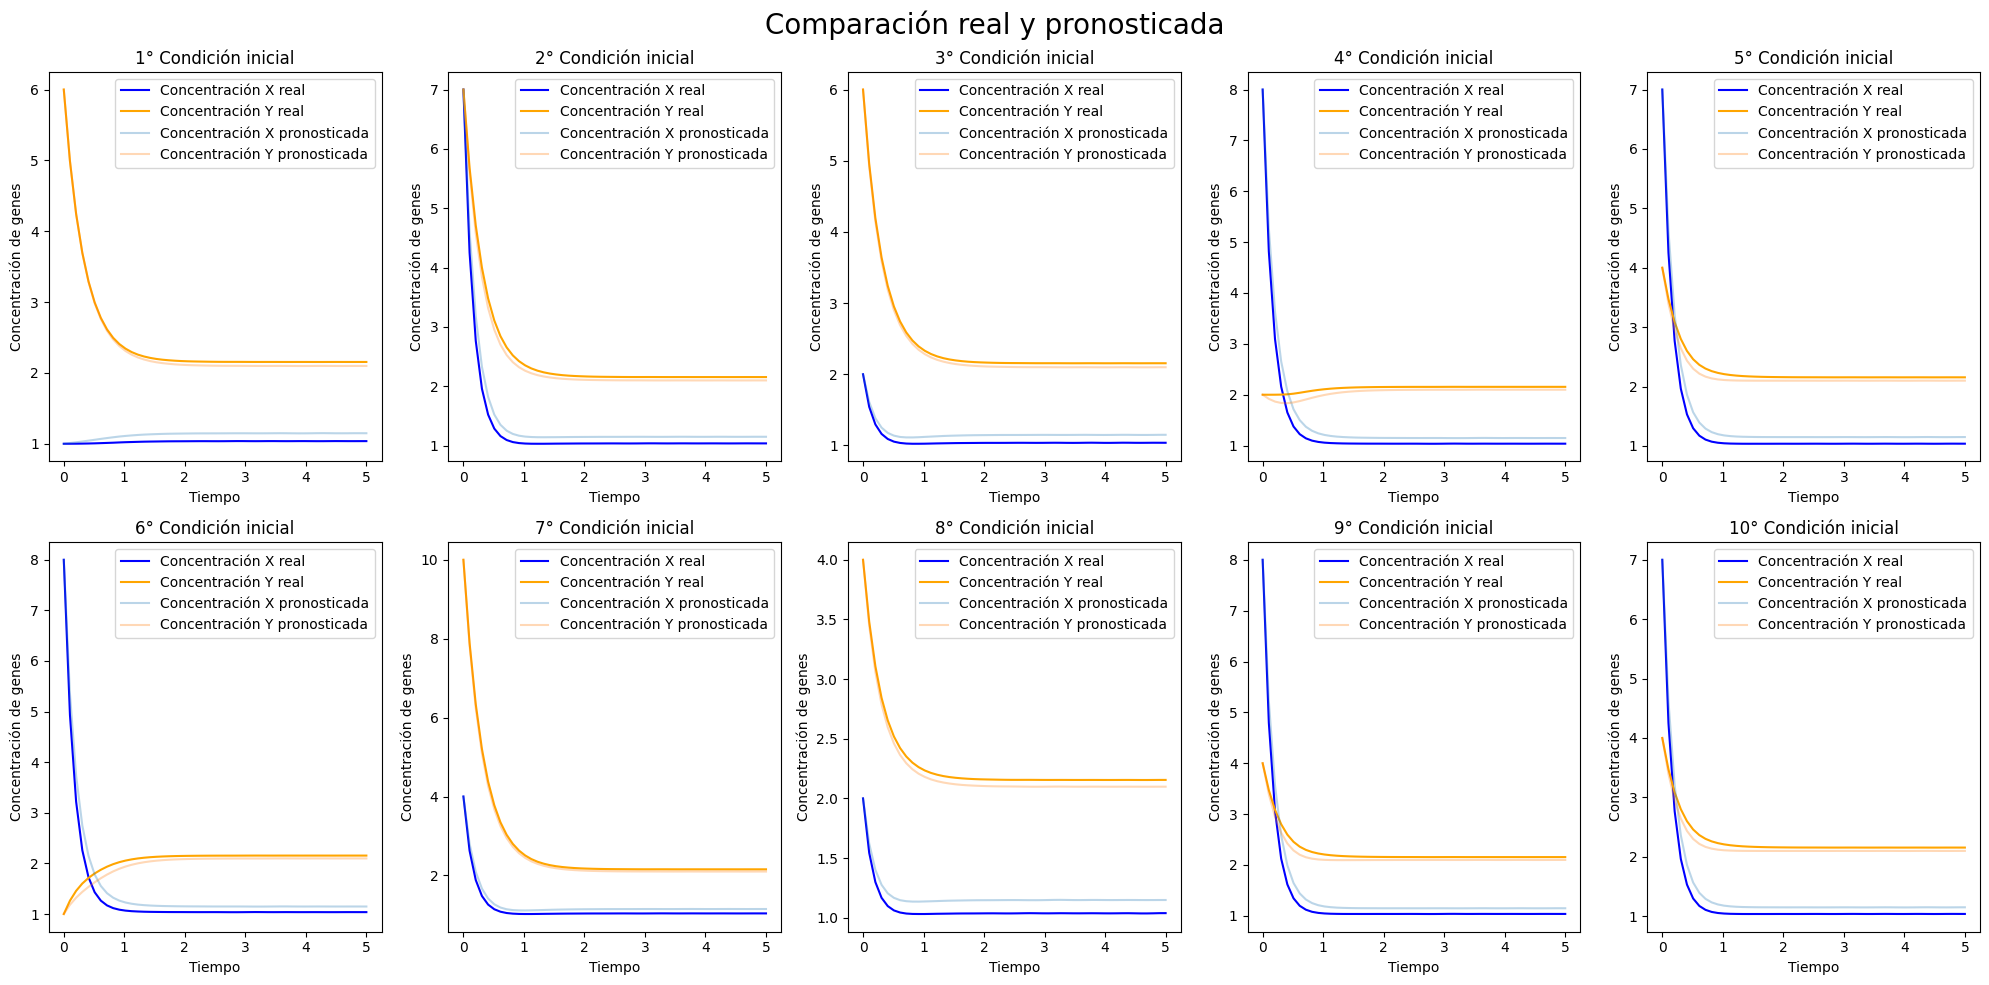

In [109]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

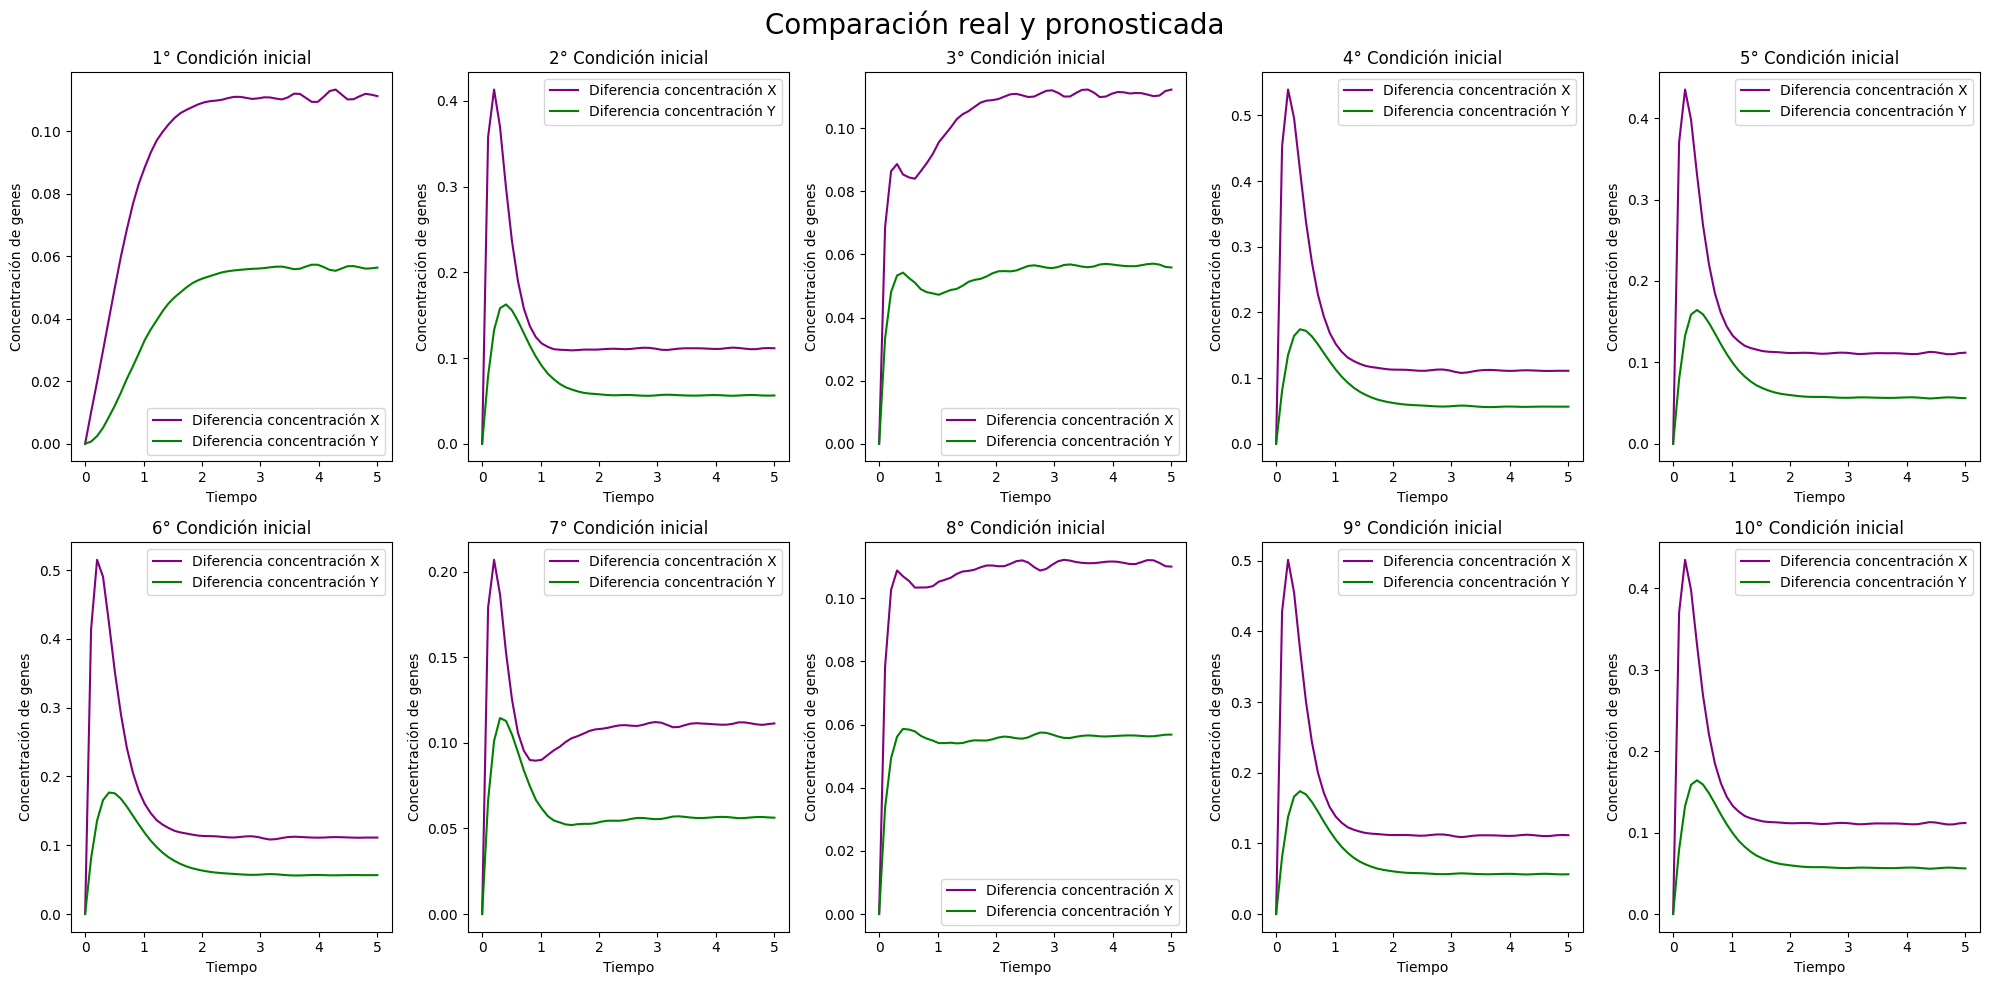

In [110]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.abs(np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :])
    diff_Y = np.abs(np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :])
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [111]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.03218202817003107
0.01649589166196283
